# Goal
I'm going to use this notebook to define conditions for stability, sweep for them, display their parameters, and visualize their runs.

In [1]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import random
import io
from IPython.display import clear_output
import time
import matplotlib.animation
import math
import pickle
from tqdm.notebook import tqdm
from collections import Counter
from matplotlib.ticker import MaxNLocator
import seaborn as sns

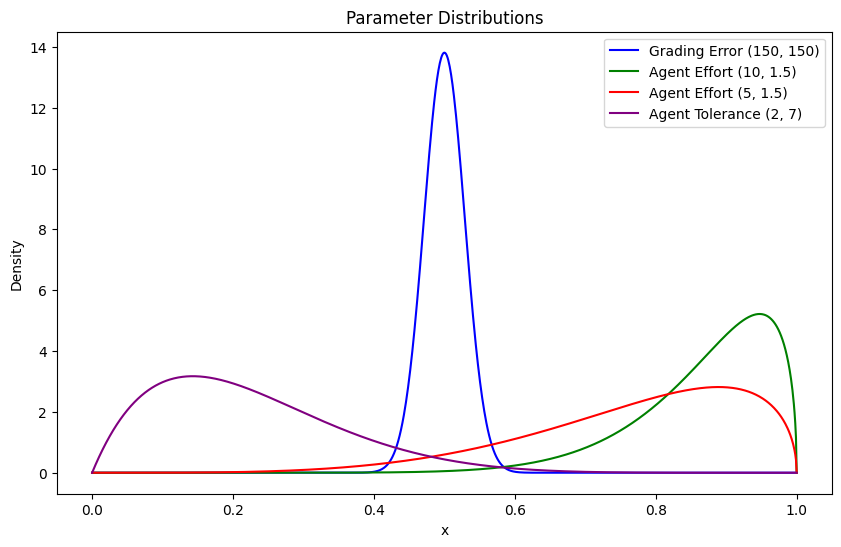

In [48]:
# redoing the beta distributions to only include relevant curves
from scipy.stats import beta
grading = (150, 150)
effort_agent = (10,1.5)
effort_agent2 = (5, 1.5)
tolerance_agent = (2,7)

# plotting
x = np.linspace(0, 1, 1000)

# Compute the beta distribution for each set of parameters
grading_dist = beta.pdf(x, grading[0], grading[1])
effort_agent_dist = beta.pdf(x, effort_agent[0], effort_agent[1])
effort_agent2_dist = beta.pdf(x, effort_agent2[0], effort_agent2[1])
tolerance_agent_dist = beta.pdf(x, tolerance_agent[0], tolerance_agent[1])

# Plot all distributions on the same plot
plt.figure(figsize=(10, 6))
plt.plot(x, grading_dist, label='Grading Error (150, 150)', color='blue')
plt.plot(x, effort_agent_dist, label='Agent Effort (10, 1.5)', color='green')
plt.plot(x, effort_agent2_dist, label='Agent Effort (5, 1.5)', color='red')
plt.plot(x, tolerance_agent_dist, label='Agent Tolerance (2, 7)', color='purple')

# Add labels, title, and legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Parameter Distributions')
plt.legend()

plt.savefig("Dists.png", format="png")
plt.show()

In [2]:
# helper funcs for loading data pipeline
def get_existing_run_headers(prefix):
    with open(f"revamped_{prefix}_existing_runs_backup.pkl", 'rb') as file:
        return pickle.load(file)

def fetch(prefix):
    agent_backup_directory = f"revamped_{prefix}/Agent_data"
    group_backup_directory = f"revamped_{prefix}/Group_data"
    
    agent_dfs = {}
    if agent_backup_directory:
        for filename in tqdm(os.listdir(agent_backup_directory), desc="Fetching Agents"):
            file_path = os.path.join(agent_backup_directory, filename)
            if os.path.isfile(file_path):
                agent_num = filename.strip('.txt.pkl').split('-')[1]
                with open(file_path, 'rb') as file:
                    agent_dfs[agent_num] = pickle.load(file)
    group_dfs = {}
    if group_backup_directory:
        for filename in tqdm(os.listdir(group_backup_directory), desc="Fetching Groups"):
            file_path = os.path.join(group_backup_directory, filename)
            if os.path.isfile(file_path):
                group_num = filename.strip('.txt.pkl').split('-')[1]
                with open(file_path, 'rb') as file:
                    group_dfs[group_num] = pickle.load(file)
    return agent_dfs, group_dfs

def human_readable(headers):
    '''
    return an array of tuples [(x,y),...] where x = human readable headers, y = human readable counts
    '''
    if isinstance(headers, str):
        '''
        just add quick handling of single strings here for ease of access
        '''
        hrable = ''.join([x + '\n' for x in headers.split("# ") if x])
        return hrable

        count_string = ""
        for key, data in counts.items():
            count_string += key + ": " + str(data) + '\n'
        readable.append((hrable, count_string))
    
    readable = []
    for header, counts in headers.items():
        hrable = ''.join([x + '\n' for x in header.split("# ") if x])

        count_string = ""
        for key, data in counts.items():
            count_string += key + ": " + str(data) + '\n'
        readable.append((hrable, count_string))
    return readable

def seedless_header(header):
    seedless = '# '.join([x + '\n' for x in header.split("# ") if 'currseed' not in x])
    return seedless

def seedless_matching(seedless, seeded):
    """
    matching seedless header to a header with seed still inside
    """
    if seedless == seedless_header(seeded):
        return True
    else:
        return False

In [3]:
# fetching functions
def stability_check(group_dfs, header, time_steps = 200):
    '''
    Doing a graphical check for stability. We can do this by plotting the number of groups that detect social loafing over time
    fetch from group dfs will be the df we're interested in looking at, group level

    Also nahhhh, we do a single plot with every run lesgoooooooo
    '''
    interested_group_runs = {}

    

    # get the first one and match other run arrays to it, should work out
    num_runs = len(group_dfs['1'][list(group_dfs['1'].keys())[0]])
    colors = plt.cm.viridis(np.linspace(0, 1, num_runs))
    
    for i in range(num_runs):
        x = list(range(time_steps))
        y = np.zeros(time_steps)
        for group_id, data in group_dfs.items():
            for run_header, run_array in data.items():
                if run_header == header:
                    interested_group_runs[group_id] = run_array[i]
                    add = run_array[i]['loafing_detected'].astype(int)
                    y += add
                    break

        coeffs = np.polyfit(x, y, 1)
        best_fit_line = np.polyval(coeffs, x)
        print(f"slope = {coeffs[0]}")
        plt.plot(x, best_fit_line, linestyle='--', color=colors[i], label=f"Line of Best Fit {i}")
        plt.plot(x, y, marker='o', linestyle='-', color=colors[i], markersize=2, label=f"Groups Detecting Loafing {i}")
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Groups')
    plt.title('Social Loafing Detection Over Time')
    plt.legend()
    plt.show()
    
    
    
    return interested_group_runs
    
    

In [4]:
# search for stability
# iterate through all the headers, calculate lines of best fits, find lowest slope, print that run
def find_stability(headers, group_dfs, num_agents, time_steps=200, idx=None, seedless=None, save=False):
    most_interested = {}
    least_coeffs = (100, 0)
    least_header = ""
    least_x = []
    least_y = []
    least_index = 0
    
    for header in tqdm(headers):
        interested_group_runs = {}
        # get the first one and match other run arrays to it, should work out
        num_runs = len(group_dfs['1'][list(group_dfs['1'].keys())[0]])

        if idx == None:
            idx = list(range(num_runs))

        if seedless:
            if seedless_matching(seedless, header):
                for i in list(range(num_runs)):
                    if i in idx:
                        x = list(range(time_steps))
                        y = np.zeros(time_steps)
                        for group_id, data in group_dfs.items():
                            for run_header, run_array in data.items():
                                if run_header == header:
                                    interested_group_runs[group_id] = run_array[i]
                                    add = run_array[i]['loafing_detected'].astype(int)
                                    y += add
                                    break
                        coeffs = np.polyfit(x, y, 1)
                        if coeffs[0] < least_coeffs[0]:
                            least_coeffs = coeffs
                            most_interested = interested_group_runs
                            least_header = header
                            least_x = x
                            least_y = y
                            least_index = i
                else:
                    pass
            else:
                for i in list(range(num_runs)):
                    if i in idx:
                            x = list(range(time_steps))
                            y = np.zeros(time_steps)
                            for group_id, data in group_dfs.items():
                                for run_header, run_array in data.items():
                                    if run_header == header:
                                        interested_group_runs[group_id] = run_array[i]
                                        add = run_array[i]['loafing_detected'].astype(int)
                                        y += add
                                        break
                            coeffs = np.polyfit(x, y, 1)
                            if coeffs[0] < least_coeffs[0]:
                                least_coeffs = coeffs
                                most_interested = interested_group_runs
                                least_header = header
                                least_x = x
                                least_y = y
                                least_index = i
                
                
    
    best_fit_line = np.polyval(least_coeffs, least_x)
    print("=======================================")
    print(human_readable(least_header))
    print(f"slope = {least_coeffs[0]}")
    plt.plot(least_x, best_fit_line, linestyle='--', color='r', label=f"{least_coeffs[0]:.3f}x")
    plt.plot(least_x, least_y, marker='o', linestyle='-', color='b', markersize=2, label=f"Number of groups with perceived loafing")
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Groups')
    plt.title(f"Run with most decrease in perceived social loafing over time(n={num_agents})")
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    if save:
        plt.savefig(f'{num_agents}_most_decrease.png', format='png')
    plt.show()

    return least_header, least_index, most_interested

def reverse_find_stability(headers, group_dfs, num_agents, time_steps=200, idx=None, seedless=None, save=False):
    most_interested = {}
    least_coeffs = (-100, 0)
    least_header = ""
    least_x = []
    least_y = []
    least_index = 0
    for header in tqdm(headers):
        interested_group_runs = {}
        # get the first one and match other run arrays to it, should work out
        num_runs = len(group_dfs['1'][list(group_dfs['1'].keys())[0]])

        if seedless:
            if seedless_matching(seedless, header):
                for i in list(range(num_runs)):
                    if i in idx:
                        x = list(range(time_steps))
                        y = np.zeros(time_steps)
                        for group_id, data in group_dfs.items():
                            for run_header, run_array in data.items():
                                if run_header == header:
                                    interested_group_runs[group_id] = run_array[i]
                                    add = run_array[i]['loafing_detected'].astype(int)
                                    y += add
                                    break
                        coeffs = np.polyfit(x, y, 1)
                        if coeffs[0] > least_coeffs[0]:
                            least_coeffs = coeffs
                            most_interested = interested_group_runs
                            least_header = header
                            least_x = x
                            least_y = y
                            least_index = i
                else:
                    pass
            else:
                for i in list(range(num_runs)):
                    if i in idx:
                            x = list(range(time_steps))
                            y = np.zeros(time_steps)
                            for group_id, data in group_dfs.items():
                                for run_header, run_array in data.items():
                                    if run_header == header:
                                        interested_group_runs[group_id] = run_array[i]
                                        add = run_array[i]['loafing_detected'].astype(int)
                                        y += add
                                        break
                            coeffs = np.polyfit(x, y, 1)
                            if coeffs[0] > least_coeffs[0]:
                                least_coeffs = coeffs
                                most_interested = interested_group_runs
                                least_header = header
                                least_x = x
                                least_y = y
                                least_index = i
                
    
    best_fit_line = np.polyval(least_coeffs, least_x)
    print("=======================================")
    print(human_readable(least_header))
    print(f"slope = {least_coeffs[0]}")
    plt.plot(least_x, best_fit_line, linestyle='--', color='r', label=f"{least_coeffs[0]:.3f}x")
    plt.plot(least_x, least_y, marker='o', linestyle='-', color='b', markersize=2, label=f"Number of groups with perceived loafing")
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Groups')
    plt.title(f"Run with least decrease in perceived social loafing over time(n={num_agents})")
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend()
    if save:
        plt.savefig(f'{num_agents}_least_decrease.png', format='png')
    plt.show()

    return least_header, least_index, most_interested

def find_stability_averaged(averaged_df, num_agents, time_steps=200, save=False):
    least_header = ""
    least_run_id = 0
    x = list(range(time_steps))
    least_y = []
    least_coeffs = (100, 0)
    for run_id, headers in tqdm(averaged_df.items()):
        for header, groups in headers.items():
            y = np.zeros(time_steps)
            for group, df in groups.items():
                y += df['loafing_detected'].values
            coeffs = np.polyfit(x, y, 1)
            if coeffs[0] < least_coeffs[0]:
                least_coeffs = coeffs
                least_header = header
                least_x = x
                least_y = y
                least_run_id = run_id
    best_fit_line = np.polyval(least_coeffs, x)
    print("=======================================")
    print(human_readable(least_header))
    print(f"slope = {least_coeffs[0]}")
    plt.plot(x, best_fit_line, linestyle='--', color='r', label=f"{least_coeffs[0]:.3f}x")
    plt.plot(x, least_y, marker='o', linestyle='-', color='b', markersize=2, label=f"Number of groups with perceived loafing")
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Groups')
    plt.title(f"Run with most decrease in perceived social loafing over time, averaged across 50 runs(n={num_agents})", fontsize=8)
    plt.legend()
    if save:
        plt.savefig(f'{num_agents}_most_decrease_average.png', format='png')
    plt.show()

    return least_header, least_run_id

def reversed_find_stability_averaged(averaged_df, num_agents, time_steps=200, save=False):
    least_header = ""
    least_run_id = 0
    x = list(range(time_steps))
    least_y = []
    least_coeffs = (-100, 0)
    for run_id, headers in tqdm(averaged_df.items()):
        for header, groups in headers.items():
            y = np.zeros(time_steps)
            for group, df in groups.items():
                y += df['loafing_detected'].values
            coeffs = np.polyfit(x, y, 1)
            if coeffs[0] > least_coeffs[0]:
                least_coeffs = coeffs
                least_header = header
                least_x = x
                least_y = y
                least_run_id = run_id
    best_fit_line = np.polyval(least_coeffs, x)
    print("=======================================")
    print(human_readable(least_header))
    print(f"slope = {least_coeffs[0]}")
    plt.plot(x, best_fit_line, linestyle='--', color='r', label=f"{least_coeffs[0]:.3f}x")
    plt.plot(x, least_y, marker='o', linestyle='-', color='b', markersize=2, label=f"Number of groups with perceived loafing")
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Groups')
    plt.title(f"Run with least decrease in perceived social loafing over time, averaged across 50 runs(n={num_agents})", fontsize=8)
    plt.legend()
    if save:
        plt.savefig(f'{num_agents}_least_decrease_average.png', format='png')
    plt.show()

    return least_header, least_run_id

In [5]:
# Accumulated paypffs?
# Do that thing where we plot payoffs relative to prior step
def plot_accumulated_payoffs(header, agent_dfs, run=0):
    interested_agent_runs = {}
    for agent_id, headers in agent_dfs.items():
        if header in headers:
            interested_agent_runs[agent_id] = headers[header][run] # How to deal with multiple runs? Dunno, let's look at one for now
    assert len(interested_agent_runs) == len(agent_dfs), "Not all agents added?"
    plt.figure(figsize=(8, 6))
    # iterate through the gathered agents
    x = interested_agent_runs['1']['steps'].copy()[1:]
    for agent, df in interested_agent_runs.items():
        y = df['accumulated_payoff'].copy()[1:]
        shift = [0] + list(y[:-1])
        y = [y_curr - y_prev for y_curr, y_prev in zip(y,shift)]
        plt.plot(x, y, lw=1, label = f"Agent {agent}")
    plt.title('Relative accumulated Payoffs')
    plt.xlabel('step')
    plt.ylabel('accumulated payoff')
    plt.show()

In [6]:
# counting divorces over the course of a run
def divorce_counter(header, group_dfs, run=0):
    interested_group_runs = {}
    global_total = 0
    for group_id, headers in group_dfs.items():
        if header in headers:
            interested_group_runs[group_id] = headers[header][run]
    assert len(interested_group_runs) == len(group_dfs), "Not all groups added?"
    x = interested_group_runs['1']['steps']
    plt.figure(figsize=(8, 6))
    for group_id, df in interested_group_runs.items():
            divorcers = [len(refs.split(':')) if ':' in str(refs) else 0 if str(refs) == 'nan' else 1 for refs in df['leaving_id'].to_list()]
            global_total += sum(divorcers)
            plt.plot(x, divorcers, lw=1)
    plt.title(f"Num Divorces Per Step Per Group, Total = {global_total}")
    plt.xlabel('step')
    plt.ylabel('Number of divorcees')
    plt.show()
    return global_total

def plot_global_divorce(header, group_dfs, run=0):
    interested_group_runs = {}
    global_total = 0
    for group_id, headers in group_dfs.items():
        if header in headers:
            interested_group_runs[group_id] = headers[header][run]
    assert len(interested_group_runs) == len(group_dfs), "Not all groups added?"
    x = interested_group_runs['1']['steps']
    plt.figure(figsize=(8, 6))
    global_divorcers = np.zeros(len(x))
    for group_id, df in interested_group_runs.items():
            divorcers = [len(refs.split(':')) if ':' in str(refs) else 0 if str(refs) == 'nan' else 1 for refs in df['leaving_id'].to_list()]
            global_total += sum(divorcers)
            global_divorcers += divorcers
    plt.plot(x, global_divorcers, lw=1)
    plt.title(f"Num Divorces Per Step All Groups, Total = {global_total}")
    plt.xlabel('step')
    plt.ylabel('Number of divorcees')
    plt.show()
    return global_total

In [7]:
def get_agents_in_group_during_run(header, run_id, agent_dfs):
    """
    For a group df, create another df composed of the interested variables of the agents over time
    """

    group_comps = {}
    
    for agent_id, headers in agent_dfs.items():
        if header in headers:
            a_df = headers[header][run_id]
            for i, row in a_df.iterrows():
                if row['group_id'] not in group_comps:
                    group_comps[row['group_id']] = {row['steps']:str(agent_id)}
                else:
                    if row['steps'] not in group_comps[row['group_id']]:
                        group_comps[row['group_id']][row['steps']] = str(agent_id)
                    else:
                        group_comps[row['group_id']][row['steps']] += f":{agent_id}"
    return group_comps

In [8]:
def run_averaging(group_dfs):
    '''
    Given a set of group_dfs, compile 5 group dfs that are averages of the columns (knock out seeds in headers and compare)
    Group -> group_payoff, step_grade, also num group with percieved loafers
    '''
    num_reps = 50
    averaged_dfs = {}

    grade_enum = {
    'F-': 0,
    'F': 1,
    'F+': 2,
    'D-': 3,
    'D': 4,
    'D+': 5,
    'C-': 6,
    'C': 7,
    'C+': 8,
    'B-': 9,
    'B': 10,
    'B+': 11,
    'A-': 12,
    'A': 13,
    'A+': 14,
    'nan': 'nan'}

    back_to_grade = {id:grade for grade,id in grade_enum.items()}

    """
    Averaged df structure
    averaged_dfs[run_id 0 - 4][seedless headers][group_ids]
    """
    
    for group_id, headers in tqdm(group_dfs.items(), desc="Strolling through the group dfs..."):
        for header, runs in headers.items():
            seedless = seedless_header(header)
            for i, run in enumerate(runs):
                # Ensure `averaged_dfs[i]` is initialized as a dictionary if it doesn't exist
                if i not in averaged_dfs:
                    averaged_dfs[i] = {}
    
                # Ensure `averaged_dfs[i][seedless]` is initialized as a dictionary if it doesn't exist
                if seedless not in averaged_dfs[i]:
                    averaged_dfs[i][seedless] = {}
                
                # Initialize or update DataFrame for the current group_id
                if group_id not in averaged_dfs[i][seedless]:
                    # Initialize with the new DataFrame and map step_grade
                    averaged_dfs[i][seedless][group_id] = pd.DataFrame(run['group_payoff']).copy()
                    averaged_dfs[i][seedless][group_id]['step_grade'] = run['step_grade'].map(grade_enum)
                    averaged_dfs[i][seedless][group_id]['loafing_detected'] = run['loafing_detected'].astype(int)
                else:
                    # Update the existing DataFrame
                    averaged_dfs[i][seedless][group_id]['group_payoff'] += run['group_payoff'].values
                    averaged_dfs[i][seedless][group_id]['step_grade'] += run['step_grade'].map(grade_enum).values
    
    for run_id, headers in averaged_dfs.items():
        for header, groups in headers.items():
            for group, df in groups.items():
                df['group_payoff'] = df['group_payoff']/num_reps
                df['step_grade'] = (df['step_grade']//num_reps).map(back_to_grade)
    return averaged_dfs

In [9]:
# get low and high points within a set of group dfs
def get_low_high(group_dfs):
    time_steps = None
    loafing_tracking = None
    for group_id, df in group_dfs.items():
        if time_steps is None:
            time_steps = df['steps'].astype(int)
        if loafing_tracking is None:
            loafing_tracking = np.zeros(len(time_steps))
        loafing_tracking += df['loafing_detected'].astype(int)
    return time_steps[np.argmin(loafing_tracking)], time_steps[np.argmax(loafing_tracking)]

# finding the agents at the exact steps
def find_agents_at_steps(group_comps, interested_runs_specific, interested_time_step): # operate under the assumption that peaks are > 5
    starting_step = interested_time_step - (interested_time_step%5)

    makeup_dict = {}
    
    if starting_step == interested_time_step:
        for group, df in group_comps.items():
            if starting_step in df:
                makeup_dict[group] = df[starting_step]
            else:
                makeup_dict[group] = ""
        return makeup_dict
    else:
        temp_comps = {}
        for group_id, df in group_comps.items():
            group_id = str(group_id)
            if starting_step in df:
                temp_comps[group_id] = str(df[starting_step]).split(':') if ':' in str(df[starting_step]) else [str(df[starting_step])]
            else:
                temp_comps[group_id] = ""
        for step in range(starting_step+1, interested_time_step+1):
            for g_id, g_df in interested_runs_specific.items():
                g_id = str(g_id)

                leavers = str(g_df['leaving_id'][step]).split(':') if ':' in str(g_df['leaving_id'][step]) else [str(g_df['leaving_id'][step])]
                for leaver in leavers: # NAN CHECk
                    if leaver != 'nan':
                        leaver = str(int(float(leaver)))
                        if leaver in temp_comps[g_id]:
                            temp_comps[g_id].remove(leaver)
                        else:
                            print(leaver)
                            print(temp_comps[g_id])
                            assert False, "weird, shouldn't be a leaver"
                joiners = str(g_df['joining_id'][step]).split(':') if ':' in str(g_df['joining_id'][step]) else [str(g_df['joining_id'][step])]
                for joiner in joiners:
                    if joiner != 'nan':
                        temp_comps[g_id].append(joiner)
        for group_id, comp in temp_comps.items():
            group_id = str(group_id)
            makeup_dict[group_id] = comp
        return makeup_dict

In [10]:
# grabbing important agent info from id, header, runid, agentdf
def grab_agent_info(agent_dfs, agent_id, header, run_id):
    agent_id = str(int(float(agent_id)))
    relevant = {}
    for _header,runs in agent_dfs[agent_id].items():
        if _header == header:
            relevant['tolerance'] = runs[run_id]['tolerance'][0]
            relevant['mean_value'] = runs[run_id]['mean_value'][0]
            relevant['grade_mean_index'] = runs[run_id]['grade_mean_index'][0]
            relevant['grade_tolerance'] = runs[run_id]['grade_tolerance'][0]
            return relevant

In [25]:
# fetching relevant data from groups
def group_stats(agent_dfs, agents, header, run_id):
    '''
    agents -> array of agent ids to look at
    '''
    num_agents = len(agents)
    if num_agents != 1:
        tolerances = []
        mean_values = []
        grade_mean_indexes = []
        grade_tolerances = []
        for agent_id in agents:
            relevant = grab_agent_info(agent_dfs, agent_id, header, run_id)
            tolerances.append(relevant['tolerance'])
            mean_values.append(relevant['mean_value'])
            if relevant['grade_mean_index'] != 'nan':
                grade_mean_indexes.append(relevant['grade_mean_index'])
                grade_tolerances.append(relevant['grade_tolerance'])
        tolerance_var = np.var(tolerances)
        mean_values_var = np.var(mean_values)
        if grade_mean_indexes:
            grade_mean_indexes_var = np.var(grade_mean_indexes)
            grade_tolerances_var = np.var(grade_tolerances)
            r = {'num_agents':num_agents, 'tolerance':tolerance_var, 'mean_value':mean_values_var, 'grade_mean_index':grade_mean_indexes_var, 'grade_tolerance':grade_tolerances_var}
            return r
        else:
            r = {'num_agents':num_agents, 'tolerance':tolerance_var, 'mean_value':mean_values_var, 'grade_mean_index':None, 'grade_tolerance':None}
            return r
    else:
        relevant = grab_agent_info(agent_dfs, agents[0], header, run_id)
        r = {'num_agents':num_agents, 'tolerance':relevant['tolerance'], 'mean_value':relevant['mean_value'], 'grade_mean_index':relevant['grade_mean_index'], 'grade_tolerance':relevant['grade_tolerance']}
        return r

def plot_group_stats(interested_groups, agent_dfs, num_agents, header, run_id, interested_time_step, group_dfs, save=False):
    '''
    use interested-time-step to find ot if group at seedless with run id i loafing or not
    separate groups in interested_groups into loafing detected or not
    plot variability accross parameters
    '''
    loaf_variance_reports = {}
    no_loaf_variance_reports = {}
    parameters_of_interest = ['tolerance', 'mean_value', 'grade_mean_index', 'grade_tolerance']
    loafing_detected = {}
    loafing_not_detected = {}
    for group_id, agents in interested_groups.items():
        loaf = bool(group_dfs[group_id][header][run_id]['loafing_detected'][interested_time_step])
        if loaf:
            loafing_detected[group_id] = group_stats(agent_dfs, agents, header, run_id)
        else:
            loafing_not_detected[group_id] = group_stats(agent_dfs, agents, header, run_id)
    for param in parameters_of_interest:
        print(param)
        fig, ax = plt.subplots()
        # loafing plots
        li = []
        lg = []
        la = []
        i = 0
        for group_id, data in loafing_detected.items():
            if data['num_agents'] > 1:
                li.append(i)
                lg.append(group_id)
                la.append(data[param])
                i += 1
        # not loafing plots
        nli = []
        nlg = []
        nla = []
        i = 0
        for group_id, data in loafing_not_detected.items():
            if data['num_agents'] > 1:
                nli.append(i)
                nlg.append(group_id)
                nla.append(data[param])
                i += 1
        nli = [len(li) + 5 + x for x in nli]

        bar_width = 1.0

        if lg and la:
            combined_loaf = list(zip(lg, la))
            combined_sorted_loaf = sorted(combined_loaf, key=lambda x: x[1])
            lg_sorted, la_sorted = zip(*combined_sorted_loaf)
            loaf_variance_reports[param] = la
        else:
            print(f"{param} not found?")
            lg_sorted = lg
            la_sorted = la
        if nlg and nla:
            combined_no_loaf= list(zip(nlg, nla))
            combined_sorted_no_loaf = sorted(combined_no_loaf, key=lambda x: x[1])
            nlg_sorted, nla_sorted = zip(*combined_sorted_no_loaf)
            no_loaf_variance_reports[param] = nla
        else:
            nlg_sorted = nlg
            nla_sorted = nla
        if nli or li:
            # BAR PLOT
            barfig, ax_bar = plt.subplots(figsize=(8, 6))
        
            # Bar plot for loafing detected
            if li:
                ax_bar.bar(li, la_sorted, color='r', width=bar_width, label=f"Loafing detected ({param}) variance")
        
            # Bar plot for loafing not detected
            if nli:
                ax_bar.bar(nli, nla_sorted, color='b', width=bar_width, label=f"Loafing not detected ({param}) variance")
            
            # Setting axis labels and title for bar plot
            ax_bar.set_xlabel('Group IDs')
            ax_bar.set_ylabel(f"{param} variance")
            ax_bar.set_title(f"Bar plot of agent {param} variance between groups with/without perceived loafing (n={num_agents})", fontsize=8)
            
            # Setting x-ticks and x-tick labels
            ax_bar.set_xticks(np.concatenate((li, nli)))
            ax_bar.set_xticklabels(np.concatenate((lg_sorted, nlg_sorted)), fontsize=5)
            
            # Display legend for bar plot
            ax_bar.legend()
            
            # Save bar plot if save is True
            if save:
                plt.savefig(f"{num_agents}_{param}_bar_variances.png", format='png')
            
            # Show bar plot
            plt.show()
    
            # KDE PLOT
            kdefig, ax_kde = plt.subplots(figsize=(8, 6))
        
            # KDE plot for loafing detected
            if la:
                sns.kdeplot(la, color='red', label=f"Loafing detected ({param}) variance", fill=True, ax=ax_kde, cut=0)
        
            # KDE plot for loafing not detected
            if nla:
                print(nla)
                sns.kdeplot(nla, color='blue', label=f"Loafing not detected ({param}) variance", fill=True, ax=ax_kde, cut=0)
            
            # Setting axis labels and title for KDE plot
            ax_kde.set_ylabel('Density')
            ax_kde.set_xlabel(f"{param} variance")
            ax_kde.set_title(f"KDE plot of agent {param} variance between groups with/without perceived loafing (n={num_agents})", fontsize=8)
            
            # Display legend for KDE plot
            ax_kde.legend()
            
            # Save KDE plot if save is True
            if save:
                plt.savefig(f"{num_agents}_{param}_kde_variances.png", format='png')
            
            # Show KDE plot
            plt.show()
    return loaf_variance_reports, no_loaf_variance_reports

In [12]:
def plot_group_agent_nums(interested_groups, save=False):
    '''
    interested_groups = dictionary
    '''
    agent_counts = [len(agents) for agents in interested_groups.values()]
    count_distribution = Counter(agent_counts)
    num_agents = list(count_distribution.keys())
    num_groups = list(count_distribution.values())
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(num_agents, num_groups, width=0.6, color='b')
    
    plt.xlabel('Number of Agents')
    plt.ylabel('Number of Groups')
    plt.title('Number of Groups per Number of Agents')
    plt.xticks(num_agents)  # Ensure all agent numbers are shown as ticks
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    if save:
        plt.savefig('groups_per_num_agents.png', format='png')
    plt.show()

In [13]:
# use a func to match if a seedless matches a header everywhere but the parameter of interest
def parameter_specific_matching(seedless, checking_header, param):
    reality_check = [x for x in seedless.split('# ') if param not in x]
    checking = [x for x in checking_header.split('# ') if param not in x]
    if reality_check == checking:
        return True
    else:
        return False

def get_param_value(header, param):
    corpus = header.strip('\n').split('# ')
    for x in corpus:
        if param in x:
            return float(x.split(': ')[-1])
    return False

In [14]:
# find correlations between parameters and attributes?
# given the averaged set of runs, and a seedless header, iterate through attributes of interest (for a start, look at the agent tolerance and agent effort distributions)
# then within those iterations (where other run parameters remain the same, check the line of best fit for num of group that detected loafing
# associate line slopes with specific parameters
def find_correlations(average_dfs, seedless):
    parameters_of_interest = ['agent_effort_alpha', 'agent_effort_beta', 'agent_tolerance_alpha', 'agent_tolerance_beta', 'agent_std_effort']
    num_max_strikes = [3, 5, 7, 11, 13]
    value_matching = {k:{} for k in num_max_strikes} #value_matching[nms][param][value] -> slope of line of best fit
    for parameter in parameters_of_interest:
        for nms, runs in average_dfs.items():
            for header, averaged_run in runs.items():
                val = None
                counts = None
                if parameter_specific_matching(seedless, header, parameter):
                    val = get_param_value(header, parameter)
                    for group, dfs in averaged_run.items():
                        if counts is not None:
                            counts += dfs['loafing_detected'].values.copy()
                        else:
                            counts = dfs['loafing_detected'].values.copy()

                    x = list(range(len(counts)))
                    coeffs = np.polyfit(x, counts, 1)
                    slope = coeffs[0]
                    print(f"{parameter}: {val}: {slope}: {num_max_strikes[nms]}")
                    if parameter not in value_matching[num_max_strikes[nms]]:
                        value_matching[num_max_strikes[nms]][parameter] = {val: {'counts': counts, 'slope':slope}}
                    else:
                        value_matching[num_max_strikes[nms]][parameter][val] = {'counts': counts, 'slope':slope}
    return value_matching

In [49]:
#plotting correlations
def plot_correlations(seedless, value_matching, nms_number, save=False):
    for param, val_dict in value_matching[nms_number].items():
        plt.figure()
        y = [v['slope'] for v in list(val_dict.values())]
        x = list(val_dict.keys())
        plt.plot(x,y, color = 'b')
        plt.xlabel(f"{param} values")
        plt.ylabel(f"Loafing detected group counts slope")
        plt.title(f"Correlation between {param} value and loafing detected group counts slope")
        if save:
            plt.savefig(f"{param} correlations.png", format="png")
        plt.show()
        plt.close()

def plot_both_correlations(least_value_matching, most_value_matching, least_nms, most_nms, save=False):
    for param, val_dict in least_value_matching[least_nms].items():
        if param in most_value_matching[most_nms]:
            if set(val_dict.keys()) == set(most_value_matching[most_nms][param]):
                plt.figure()
                x = list(val_dict.keys())
                least_y = [v['slope'] for v in list(val_dict.values())]
                most_y = [v['slope'] for v in list(most_value_matching[most_nms][param].values())]
                plt.plot(x, least_y, color='b', label="Run with most decrease in social loafing")
                plt.plot(x, most_y, color='r', label = "Run with least decrease in social loafing")
                plt.xlabel(f"{param} values")
                plt.ylabel(f"Loafing detected group counts slope")
                plt.title(f"Correlation between {param} value and loafing detected group counts slope", fontsize=8)
                plt.legend()
                if save:
                    plt.savefig(f"BOTH {param} correlations.png", format="png")
                plt.show()
                plt.close()

# END FUNCTIONS

In [ ]:
test = get_existing_run_headers('true_200')
th = list(test.keys())[0]
print(human_readable(th))
_ = stability_check(g, th)

In [ ]:
# 60
a_60, g_60 = fetch('true_60_backup')

In [ ]:
headers_60 = get_existing_run_headers('true_60')
lowest_header_60, lowest_run_id = find_stability(headers_60, g_60)

In [ ]:
# 150
a_150, g_150 = fetch('true_150_backup')

In [ ]:
del a_150
del g_150

In [ ]:
headers_150 = get_existing_run_headers('true_150')
lowest_header_150 = find_stability(headers_150, g_150)

In [ ]:
lowest_header, lowest_run_id = find_stability(test, g)

In [ ]:
# plotting some beta distributions for visualization on the poster
from scipy.stats import beta

In [ ]:
# plot the grading error curves, agent error curves, and agent tolerance curves
grading_error_alpha = 150
grading_error_beta = 150

agent_effort_alpha = [5, 10]
agent_effort_beta = [1.5, 3, 5]

agent_tolerance_alpha = [1, 2]
agent_tolerance_beta = [1, 7]
# parameters to plot

In [ ]:
# actually plotting
x = np.linspace(0, 1, 1000) # x for beta to be plotted accross

# grading error
pdf_grading_error = beta.pdf(x, grading_error_alpha, grading_error_beta)
plt.figure(figsize=(8, 6))
plt.plot(x, pdf_grading_error, 'b-', lw=2, label=f'Grading Error ({grading_error_alpha}, {grading_error_beta})')

# agent effort distributions beta must be < alpha
combinations = [(a, b) for a in agent_effort_alpha for b in agent_effort_beta if b < a]

for (a,b) in combinations:
    pdf_agent_effort = beta.pdf(x, a, b)
    plt.plot(x, pdf_agent_effort, lw=2, label = f"Agent Effort ({a}, {b})")

# agent tolerances, only (1,1) and tolerance alpha < tolerance beta
tolerance_combinations = [(a, b) for a in agent_tolerance_alpha for b in agent_tolerance_beta if (b > a and (b != a and a != 1)) or b == a]
for (a,b) in tolerance_combinations:
    pdf_agent_effort = beta.pdf(x, a, b)
    plt.plot(x, pdf_agent_effort, lw=2, label = f"Tolerance Distributions ({a}, {b})")

plt.title('Parameter Beta Distributions')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.savefig('beta_distributions_plot.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
# a_200, g_200 = fetch('true_200_backup')
# headers_200 = get_existing_run_headers('true_200')
lowest_header_200, least_index = find_stability(headers_200, g_200)

In [ ]:
most_header_200, most_index = reverse_find_stability(headers_200, g_200)

In [ ]:
plot_accumulated_payoffs(lowest_header_200, a_200, least_index)

In [ ]:
total_divorces_200 = divorce_counter(lowest_header_200, g_200, least_index)

In [ ]:
total_divorces_200 = plot_global_divorce(lowest_header_200, g_200, least_index)

In [ ]:
# Group composition lookup
# Relate group composition (agent makeup in a group, how does mean effort compare between agents within a group?)
# How does perceived social loafing correlate to group makeups? -> natching if group['loafing_detected'] = True, 

# also checking at lowest proportion of social loafing at each step, what do group makeups look like at that time/
# equivalently, what do group makeups look like at the steps where the proportion of groups detecting loafing is highest

# START PIPELINES

In [15]:
# fetch
a_150, g_150 = fetch('true_150_backup')

Fetching Agents:   0%|          | 0/150 [00:00<?, ?it/s]

Fetching Groups:   0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
headers_150 = get_existing_run_headers('true_150')

In [17]:
averaged_g_150 = run_averaging(g_150)

Strolling through the group dfs...:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]



num_agents: 150

min_agents_per_group: 3

max_agents_per_group: 4

letter_grades: true

grading_error_alpha: 150.0

grading_error_beta: 150.0

agent_effort_alpha: 5.0

agent_effort_beta: 3.0

agent_std_effort: 0.01

divorce_constant: 50.0

agent_tolerance_alpha: 2.0

agent_tolerance_beta: 7.0

group_track_rate: 1

agent_track_rate: 5


slope = -0.015562889072226837


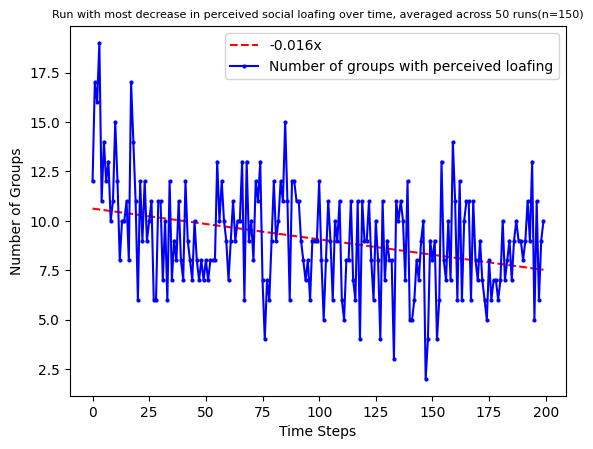

In [18]:
least_header_150, least_run_id_150 = find_stability_averaged(averaged_g_150, 150, save=True)

In [19]:
correlates = find_correlations(averaged_g_150, least_header_150)

agent_effort_alpha: 5.0: -0.008766219155478915: 3
agent_effort_alpha: 10.0: -0.00015225380634517648: 3
agent_effort_alpha: 5.0: -0.008486462161554072: 5
agent_effort_alpha: 10.0: -0.0058073951848796185: 5
agent_effort_alpha: 5.0: -0.009294982374559413: 7
agent_effort_alpha: 10.0: -0.006147903697592446: 7
agent_effort_alpha: 5.0: -0.014289357233930891: 11
agent_effort_alpha: 10.0: -0.00224705617640441: 11
agent_effort_alpha: 5.0: -0.015562889072226837: 13
agent_effort_alpha: 10.0: -0.00960174004350111: 13
agent_effort_beta: 1.5: -0.0022320558013950633: 3
agent_effort_beta: 3.0: -0.008766219155478915: 3
agent_effort_beta: 1.5: -0.004321608040201061: 5
agent_effort_beta: 3.0: -0.008486462161554072: 5
agent_effort_beta: 1.5: -0.009336983424585632: 7
agent_effort_beta: 3.0: -0.009294982374559413: 7
agent_effort_beta: 1.5: -0.008475961899047512: 11
agent_effort_beta: 3.0: -0.014289357233930891: 11
agent_effort_beta: 1.5: -0.005052876321908067: 13
agent_effort_beta: 3.0: -0.015562889072226837

In [178]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in correlates[13]['agent_effort_alpha'].items()]))

5.0: -0.015562889072226837
10.0: -0.00960174004350111



In [36]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in correlates[13]['agent_effort_beta'].items()]))

1.5: -0.005052876321908067
3.0: -0.015562889072226837



In [180]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in correlates[13]['agent_tolerance_alpha'].items()]))

2.0: -0.015562889072226837



In [181]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in correlates[13]['agent_tolerance_beta'].items()]))

7.0: -0.015562889072226837



In [44]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in correlates[13]['agent_std_effort'].items()]))

0.01: -0.015562889072226837
0.05: -0.012143553588839735
0.075: -0.009884497112427839
0.1: -0.003388584714617928
0.2: -0.0021023025575639632



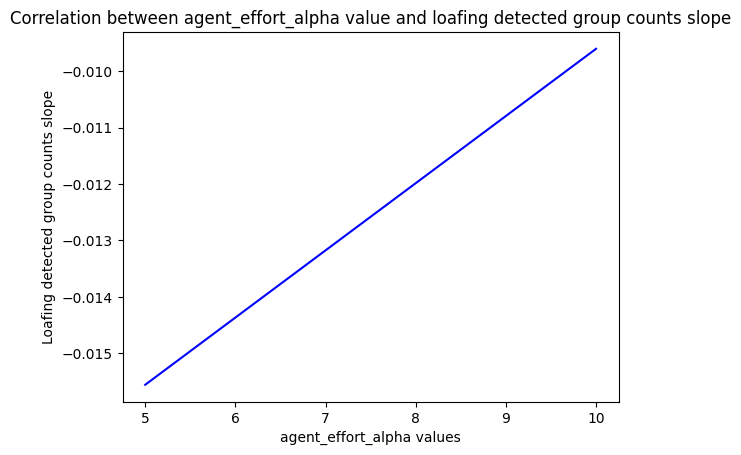

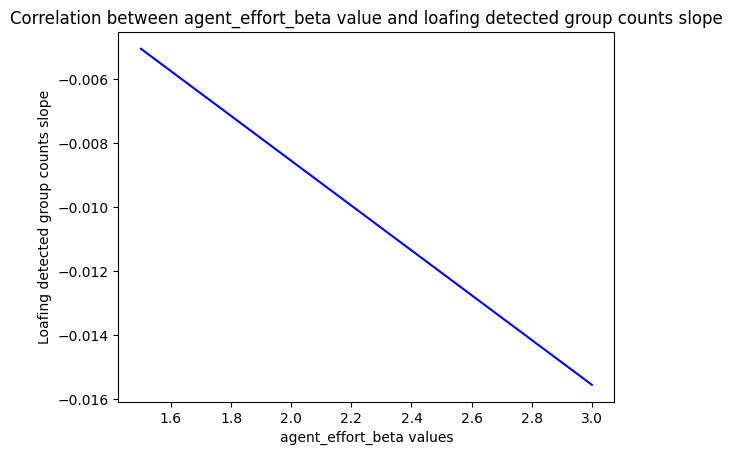

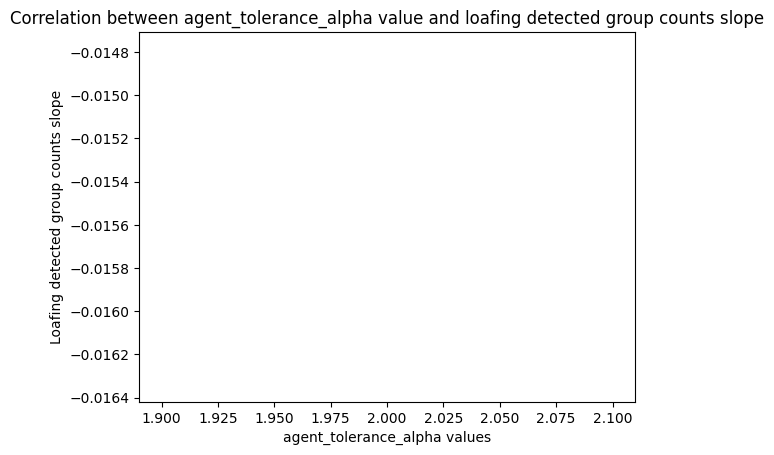

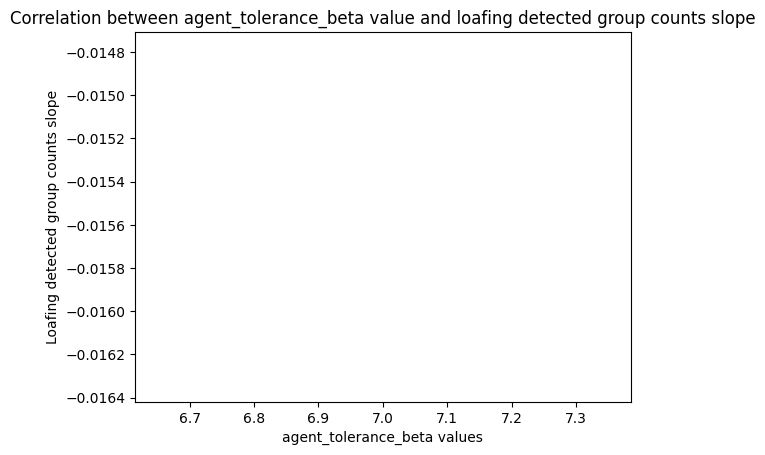

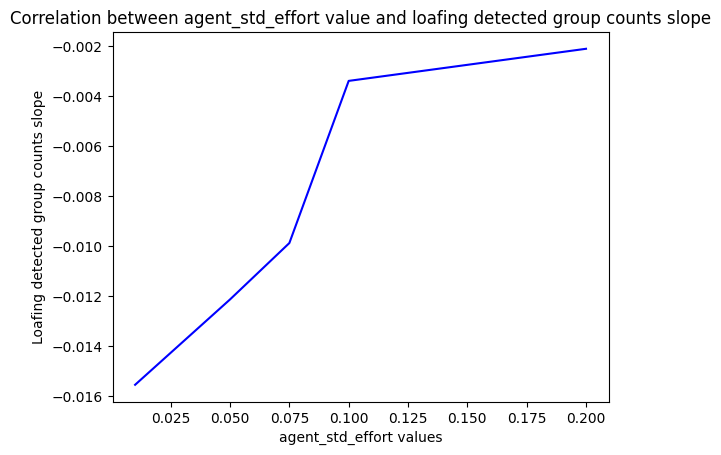

In [35]:
plot_correlations(least_header_150, correlates, 13, save=False)

  0%|          | 0/1250 [00:00<?, ?it/s]

num_agents: 150
min_agents_per_group: 3
max_agents_per_group: 4
letter_grades: true
grading_error_alpha: 150.0
grading_error_beta: 150.0
agent_effort_alpha: 5.0
agent_effort_beta: 1.5
agent_std_effort: 0.01
divorce_constant: 50.0
agent_tolerance_alpha: 2.0
agent_tolerance_beta: 7.0
currseed: 14
group_track_rate: 1
agent_track_rate: 5

slope = -0.024928373209330248


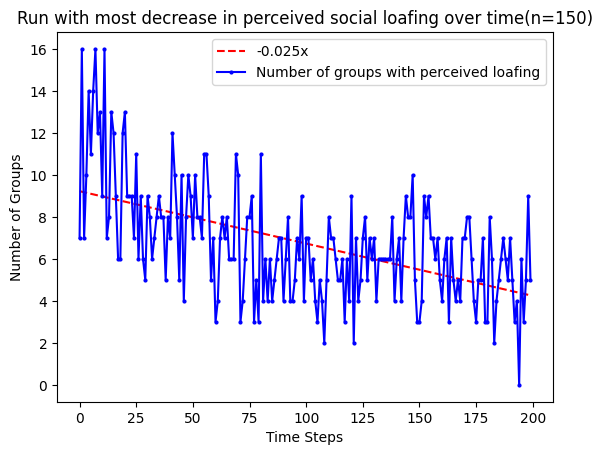

In [20]:
# find stability within a section of headers and run_ids. differentiating seeds
least_header_150_specific, least_run_id_150_specific, interested_runs_specific = find_stability(headers_150, g_150, 150, idx=[least_run_id_150], seedless=least_header_150, save = True)

In [21]:
# getting the low high points of the given run
low_point, high_point = get_low_high(interested_runs_specific)

In [22]:
# fetch group compositions
group_comps = get_agents_in_group_during_run(least_header_150_specific, least_run_id_150_specific, a_150)

In [23]:
comp_at_step = find_agents_at_steps(group_comps, interested_runs_specific, low_point)

In [ ]:
plot_group_agent_nums(comp_at_step)

tolerance
tolerance not found?


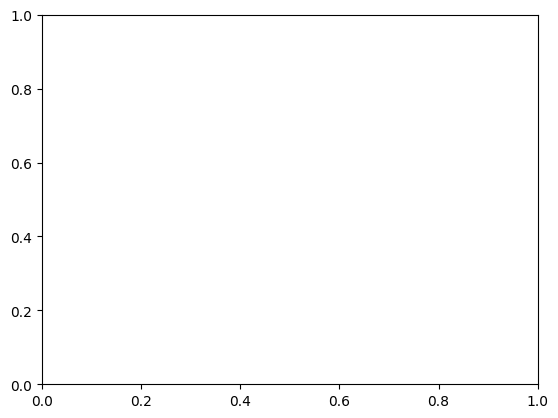

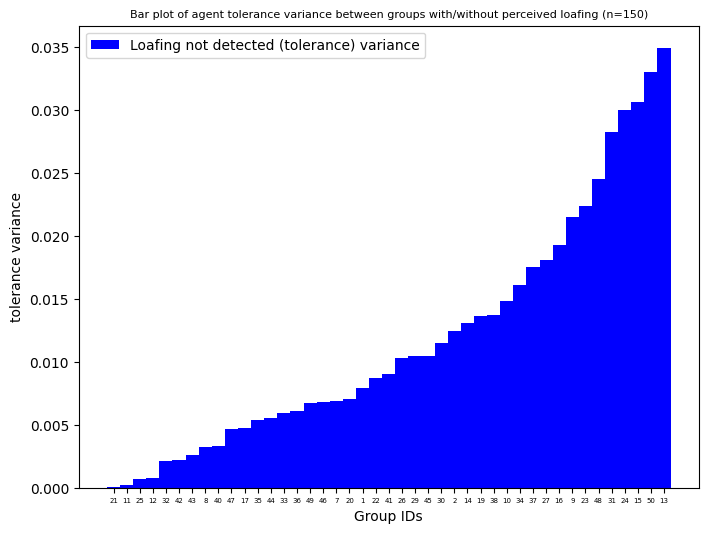

[np.float64(0.007920482473344061), np.float64(0.0021639456477552804), np.float64(0.011458684040758171), np.float64(0.016128711624279753), np.float64(0.005360751533965284), np.float64(4.057643728691277e-05), np.float64(0.009013210608119398), np.float64(0.0061173041295778776), np.float64(0.010470750224114695), np.float64(0.008685188167565958), np.float64(0.004672024570526617), np.float64(0.03492128376659959), np.float64(0.017517749629588405), np.float64(0.013611065315642908), np.float64(0.0007792876382149427), np.float64(0.013701393831585256), np.float64(0.006843566839568285), np.float64(0.010317216427706404), np.float64(0.002103182266327538), np.float64(0.012467622877075887), np.float64(0.004776390296758799), np.float64(0.003323055374997994), np.float64(0.00551619175480163), np.float64(0.02998505685908899), np.float64(0.014822563840180887), np.float64(0.006824208446127586), np.float64(0.006697925019703888), np.float64(0.03062877374802101), np.float64(0.0032241695661412656), np.float64(0

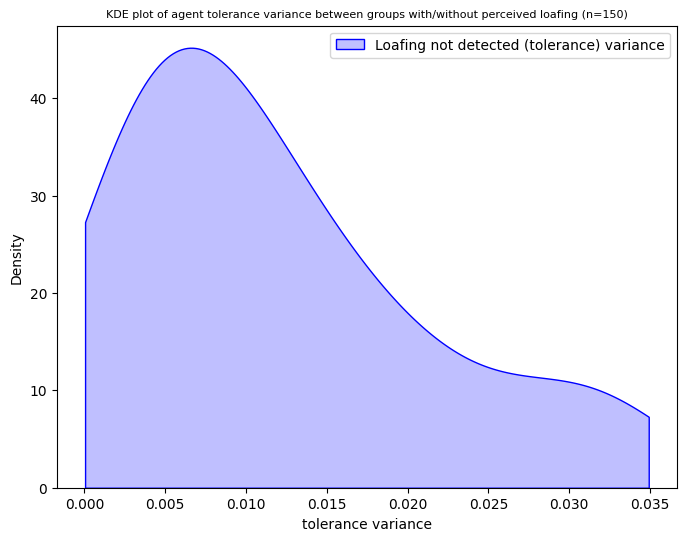

mean_value
mean_value not found?


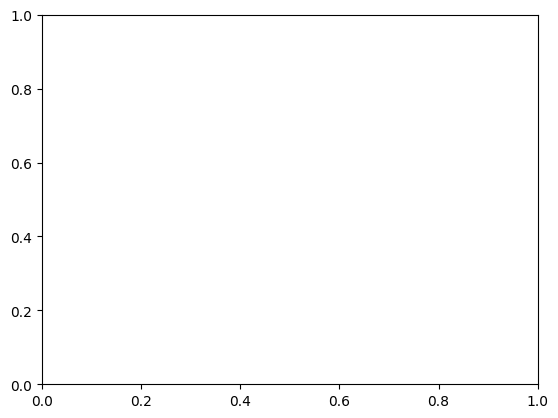

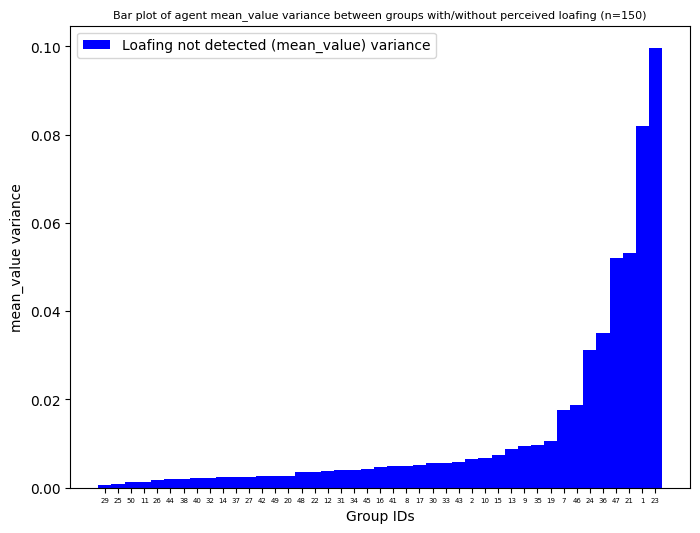

[np.float64(0.08202545219599792), np.float64(0.002544129078298862), np.float64(0.005523896929938143), np.float64(0.004060193692451242), np.float64(0.009635822437873809), np.float64(0.05308353553762143), np.float64(0.005010709948370263), np.float64(0.03503402466916588), np.float64(0.0007061651199306407), np.float64(0.0036577113153757404), np.float64(0.052163035423797605), np.float64(0.00870539907615809), np.float64(0.0024974587264818575), np.float64(0.010537148615701836), np.float64(0.0038435753965795367), np.float64(0.001988483104293741), np.float64(0.017683419545315746), np.float64(0.0018413502468045163), np.float64(0.0021781458120850423), np.float64(0.006609970912369485), np.float64(0.005223017066613713), np.float64(0.002092506391251577), np.float64(0.001963530900486716), np.float64(0.03122733787941611), np.float64(0.006787412957848911), np.float64(0.01877233846060345), np.float64(0.002634103893920294), np.float64(0.007500174243200834), np.float64(0.005012305128165292), np.float64(0.

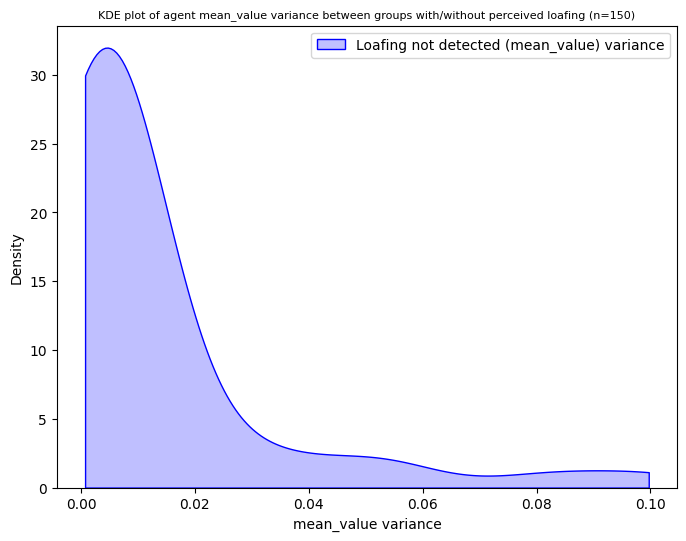

grade_mean_index
grade_mean_index not found?


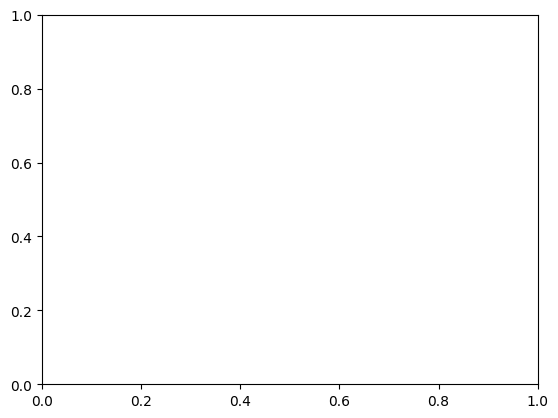

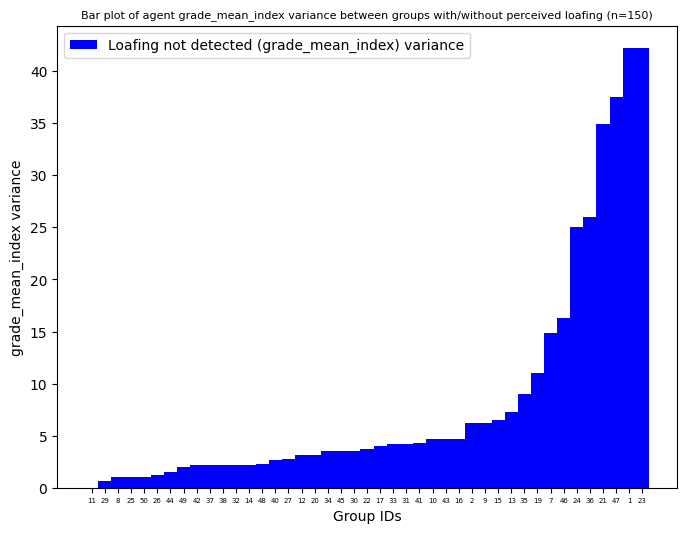

[np.float64(42.25), np.float64(2.1875), np.float64(3.5555555555555554), np.float64(3.5), np.float64(9.0), np.float64(34.888888888888886), np.float64(4.25), np.float64(26.0), np.float64(0.6666666666666666), np.float64(3.6875), np.float64(37.555555555555564), np.float64(7.25), np.float64(2.1875), np.float64(11.0), np.float64(3.1875), np.float64(2.1875), np.float64(14.888888888888891), np.float64(1.1875), np.float64(2.1875), np.float64(6.1875), np.float64(4.0), np.float64(2.6666666666666665), np.float64(1.5555555555555556), np.float64(25.0), np.float64(4.666666666666667), np.float64(16.25), np.float64(2.0), np.float64(6.5), np.float64(1.0), np.float64(4.1875), np.float64(4.6875), np.float64(42.25), np.float64(1.0), np.float64(1.0), np.float64(4.6875), np.float64(3.5), np.float64(3.1875), np.float64(4.222222222222222), np.float64(0.0), np.float64(2.25), np.float64(6.25), np.float64(2.1875), np.float64(2.75)]


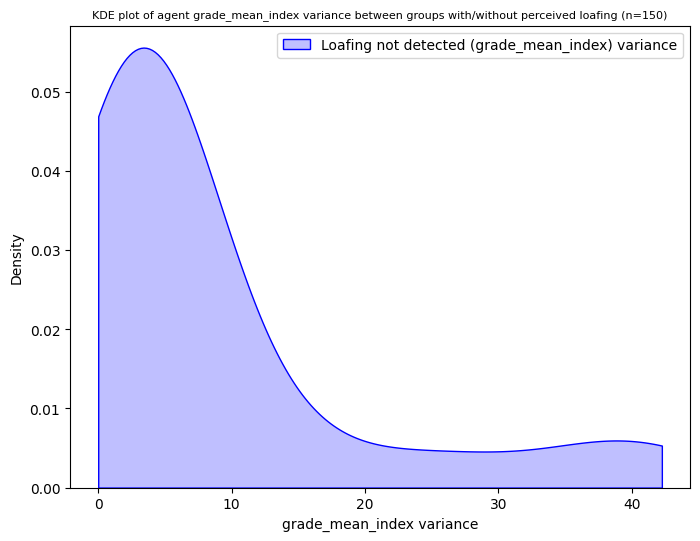

grade_tolerance
grade_tolerance not found?


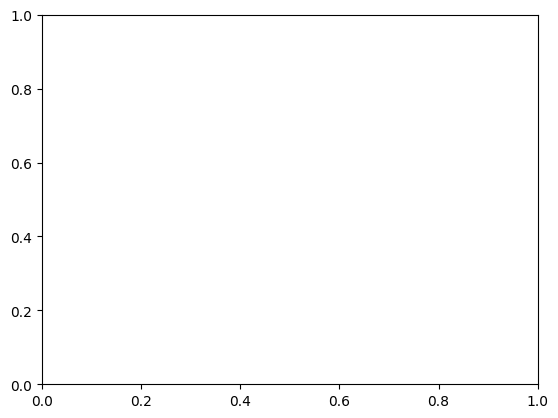

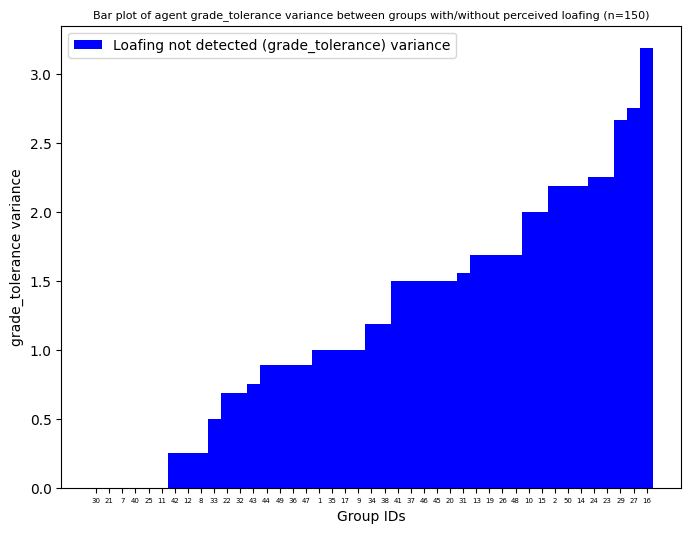

[np.float64(1.0), np.float64(0.25), np.float64(0.0), np.float64(1.1875), np.float64(1.0), np.float64(0.0), np.float64(1.5), np.float64(0.888888888888889), np.float64(2.6666666666666665), np.float64(0.6875), np.float64(0.888888888888889), np.float64(1.6875), np.float64(1.5), np.float64(1.6875), np.float64(0.25), np.float64(1.1875), np.float64(0.0), np.float64(1.6875), np.float64(0.6875), np.float64(2.1875), np.float64(1.0), np.float64(0.0), np.float64(0.8888888888888888), np.float64(2.25), np.float64(2.0), np.float64(1.5), np.float64(0.8888888888888888), np.float64(2.0), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(2.25), np.float64(0.0), np.float64(2.1875), np.float64(3.1875), np.float64(1.5), np.float64(1.5), np.float64(1.5555555555555554), np.float64(0.0), np.float64(1.6875), np.float64(1.0), np.float64(2.1875), np.float64(2.75)]


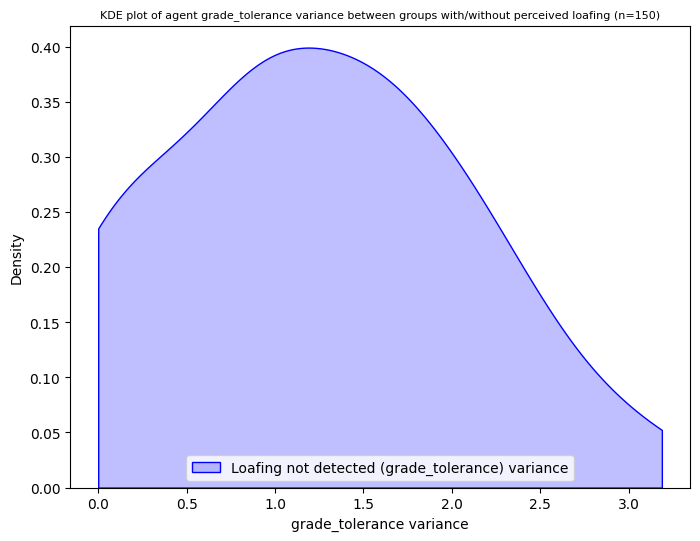

In [26]:
loaf_variances, no_loaf_variances = plot_group_stats(comp_at_step, a_150, 150, least_header_150_specific, least_run_id_150_specific, low_point, g_150, save=True)

In [ ]:
no_loaf_variances.keys()

# FIND THE MOSTEST PIPELINE

  0%|          | 0/5 [00:00<?, ?it/s]



num_agents: 150

min_agents_per_group: 3

max_agents_per_group: 4

letter_grades: true

grading_error_alpha: 150.0

grading_error_beta: 150.0

agent_effort_alpha: 10.0

agent_effort_beta: 1.5

agent_std_effort: 0.2

divorce_constant: 50.0

agent_tolerance_alpha: 2.0

agent_tolerance_beta: 7.0

group_track_rate: 1

agent_track_rate: 5


slope = 0.01236555913897846


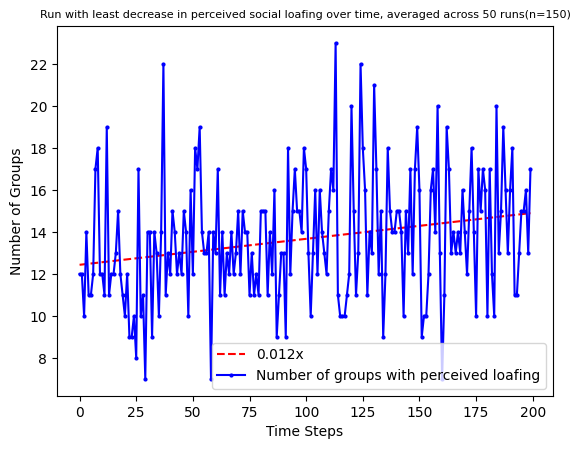

In [37]:
most_header_150, most_run_id_150 = reversed_find_stability_averaged(averaged_g_150, 150, save=True)

In [38]:
# reversed correlates
reversed_correlates = find_correlations(averaged_g_150, most_header_150)

agent_effort_alpha: 5.0: 0.0026453161329033047: 3
agent_effort_alpha: 10.0: -0.0009577739443486449: 3
agent_effort_alpha: 5.0: 0.008586964674116817: 5
agent_effort_alpha: 10.0: -0.0009240231005775534: 5
agent_effort_alpha: 5.0: -0.004947123678091985: 7
agent_effort_alpha: 10.0: 0.0037995949898747524: 7
agent_effort_alpha: 5.0: 0.00602865071626787: 11
agent_effort_alpha: 10.0: 0.01236555913897846: 11
agent_effort_alpha: 5.0: 0.009864996624915592: 13
agent_effort_alpha: 10.0: 0.010174754368859161: 13
agent_effort_beta: 1.5: -0.0009577739443486449: 3
agent_effort_beta: 3.0: 0.0014895372384309481: 3
agent_effort_beta: 5.0: -0.002220805520138032: 3
agent_effort_beta: 1.5: -0.0009240231005775534: 5
agent_effort_beta: 3.0: 0.004714617865446613: 5
agent_effort_beta: 5.0: 0.002322058051451277: 5
agent_effort_beta: 1.5: 0.0037995949898747524: 7
agent_effort_beta: 3.0: 0.0006697667441685728: 7
agent_effort_beta: 5.0: -0.00213530338258465: 7
agent_effort_beta: 1.5: 0.01236555913897846: 11
agent_ef

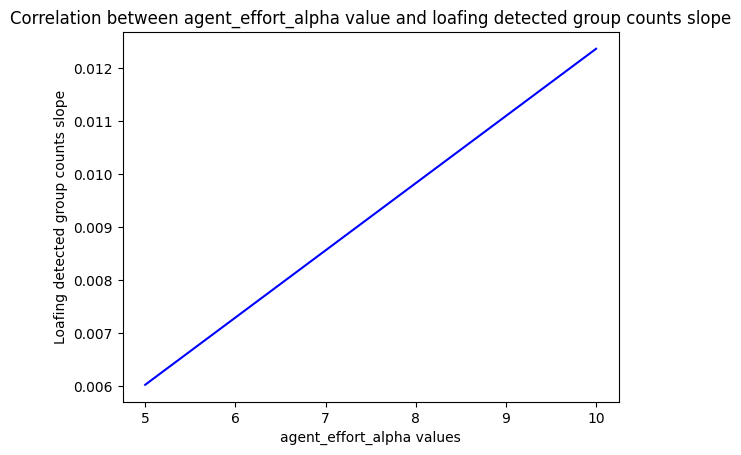

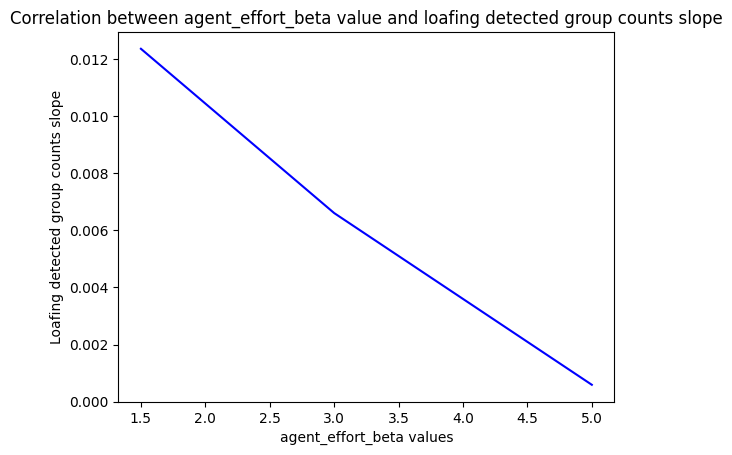

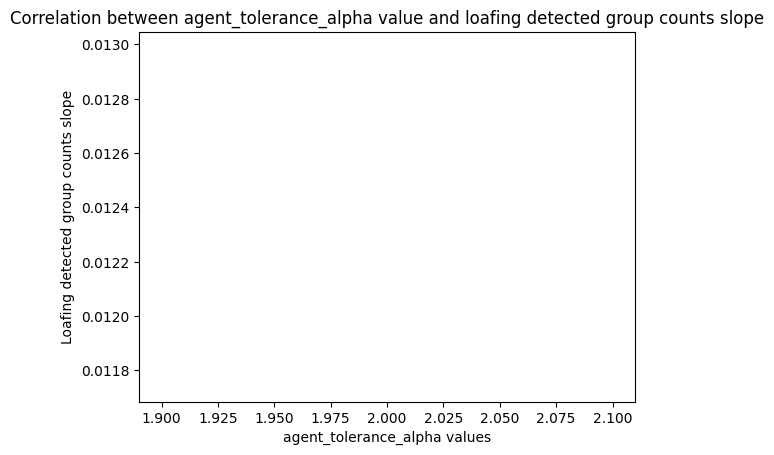

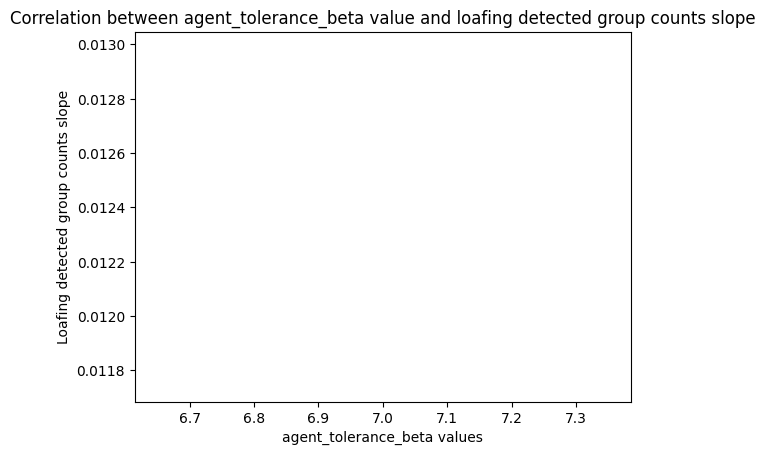

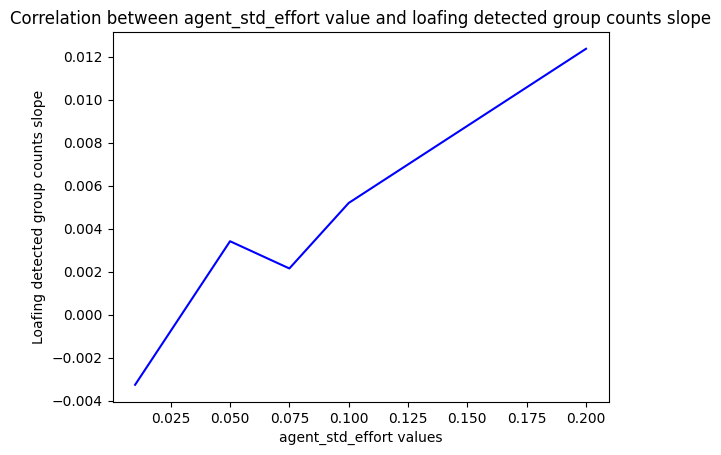

In [39]:
plot_correlations(most_header_150, reversed_correlates, 11, save=False)

In [185]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in reversed_correlates[11]['agent_effort_alpha'].items()]))

5.0: 0.00602865071626787
10.0: 0.01236555913897846



In [186]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in reversed_correlates[11]['agent_effort_beta'].items()]))

1.5: 0.01236555913897846
3.0: 0.006607665191629776
5.0: 0.0005887647191179155



In [187]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in reversed_correlates[11]['agent_tolerance_alpha'].items()]))

2.0: 0.01236555913897846



In [188]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in reversed_correlates[11]['agent_tolerance_beta'].items()]))

7.0: 0.01236555913897846



In [189]:
print(''.join([f"{val}: {data['slope']}\n" for val, data in reversed_correlates[11]['agent_std_effort'].items()]))

0.01: -0.0032678316957924
0.05: 0.0034110852771319033
0.075: 0.0021443036075901654
0.1: 0.005190879771994277
0.2: 0.01236555913897846



  0%|          | 0/1250 [00:00<?, ?it/s]

num_agents: 150
min_agents_per_group: 3
max_agents_per_group: 4
letter_grades: true
grading_error_alpha: 150.0
grading_error_beta: 150.0
agent_effort_alpha: 10.0
agent_effort_beta: 1.5
agent_std_effort: 0.2
divorce_constant: 50.0
agent_tolerance_alpha: 2.0
agent_tolerance_beta: 7.0
currseed: 48
group_track_rate: 1
agent_track_rate: 5

slope = 0.015951398784969602


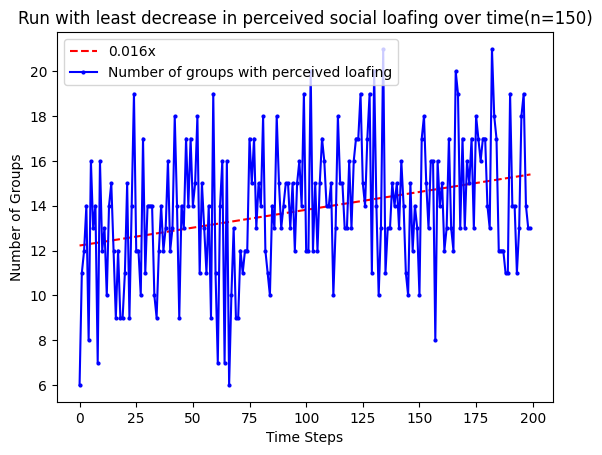

In [29]:
# find stability within a section of headers and run_ids. differentiating seeds
most_header_150_specific, most_run_id_150_specific, interested_runs_specific_most = reverse_find_stability(headers_150, g_150,150, idx=[most_run_id_150], seedless=most_header_150, save = True)

In [30]:
low_point_most, high_point_most = get_low_high(interested_runs_specific_most)

In [31]:
# fetch group compositions
group_comps_most = get_agents_in_group_during_run(most_header_150_specific, most_run_id_150_specific, a_150)

In [32]:
comp_at_step_most = find_agents_at_steps(group_comps_most, interested_runs_specific_most, high_point_most)

In [ ]:
plot_group_agent_nums(comp_at_step_most)

C:\Users\Timo_L\anaconda3\envs\my_coop\Lib\site-packages\numpy\_core\fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Timo_L\anaconda3\envs\my_coop\Lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Timo_L\anaconda3\envs\my_coop\Lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


tolerance


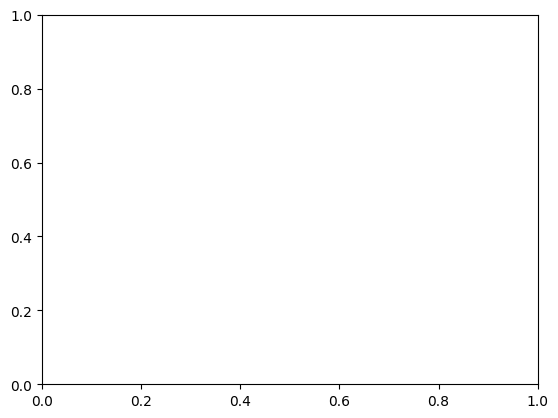

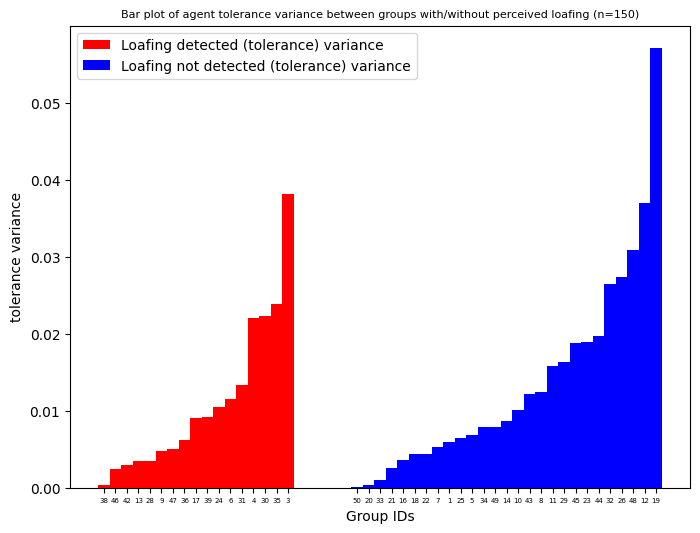

[np.float64(0.005903879491052466), np.float64(0.036983656285335786), np.float64(0.0025367095756673023), np.float64(0.05714016497802148), np.float64(0.018873788774113165), np.float64(0.007876294039497925), np.float64(0.00357520983212366), np.float64(0.018808116072955926), np.float64(0.004386179434278866), np.float64(0.027341656789096003), np.float64(0.005226514120536181), np.float64(0.030850090457982534), np.float64(0.00010806387544258776), np.float64(0.008720265769059021), np.float64(0.007894676167094813), np.float64(0.004352512119219317), np.float64(0.01004571946683593), np.float64(0.016318313785991845), np.float64(0.01238187071857331), np.float64(0.0064268596536867255), np.float64(0.006788075682397204), np.float64(0.0010229395992932635), np.float64(0.015804312882079022), np.float64(0.012222213362369389), np.float64(0.01972603747323596), np.float64(0.00038639102294136374), np.float64(0.026513474218009293)]


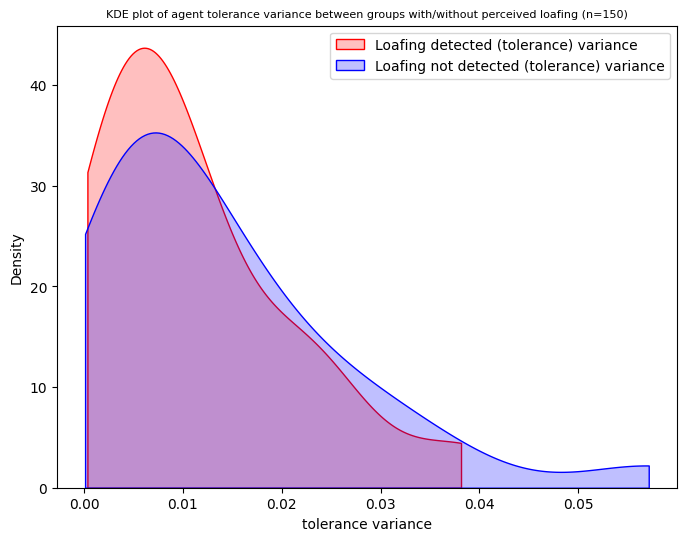

mean_value


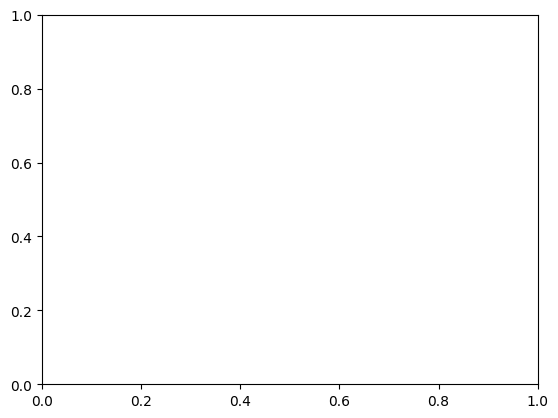

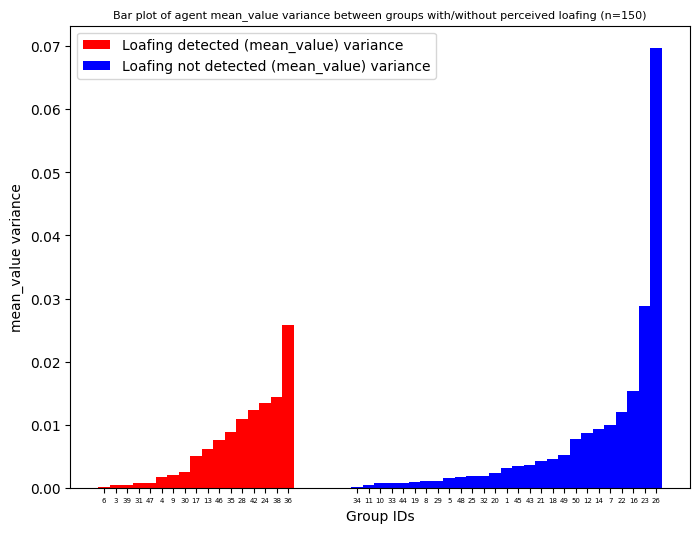

[np.float64(0.0030921503821959326), np.float64(0.008731516537104737), np.float64(0.004291667490033751), np.float64(0.0008830836937905083), np.float64(0.028785300766267674), np.float64(0.00012175759412573687), np.float64(0.015415542515034195), np.float64(0.003473819248837799), np.float64(0.011983889894291578), np.float64(0.06976870261319373), np.float64(0.009891877476965611), np.float64(0.001769958270043506), np.float64(0.0077645628536708545), np.float64(0.009298961219237806), np.float64(0.005234147114155017), np.float64(0.004523554854878453), np.float64(0.0007407763494544054), np.float64(0.0010346131010876044), np.float64(0.0010209498629960448), np.float64(0.0018093860967781893), np.float64(0.0015469594599848218), np.float64(0.000749043241906438), np.float64(0.00047249414474526564), np.float64(0.0035549355795675393), np.float64(0.0007646693293023183), np.float64(0.0023194014761677077), np.float64(0.0018311582594189428)]


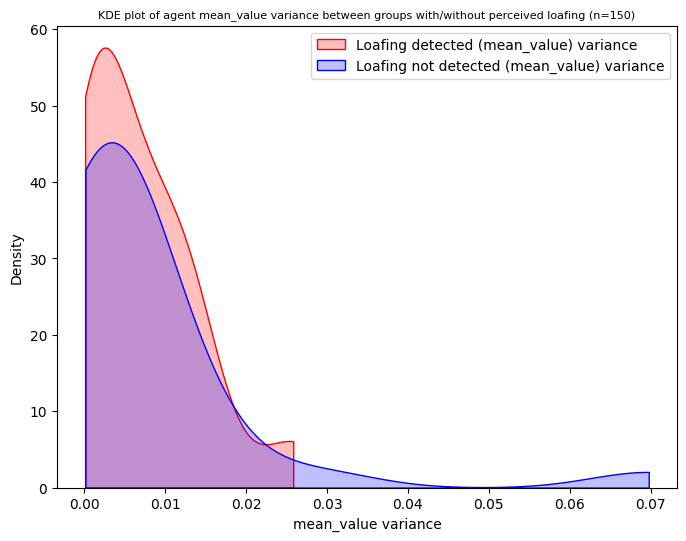

grade_mean_index


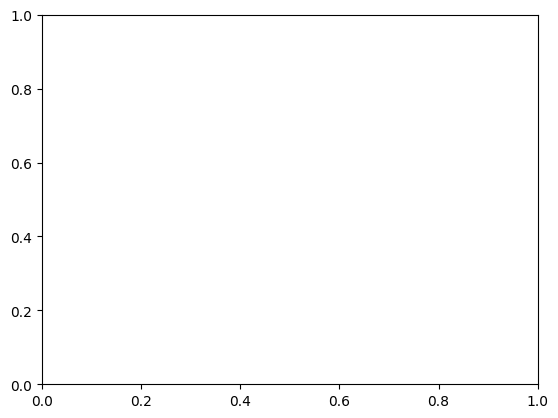

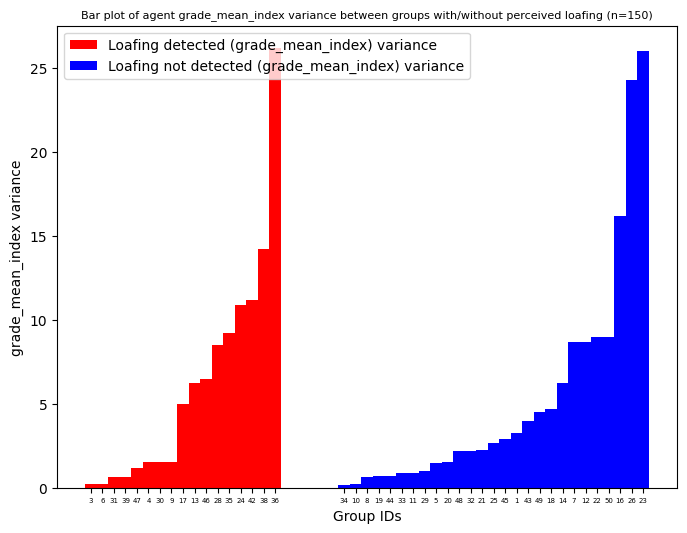

[np.float64(3.25), np.float64(8.6875), np.float64(2.25), np.float64(0.6875), np.float64(26.0), np.float64(0.1875), np.float64(16.1875), np.float64(2.8888888888888893), np.float64(9.0), np.float64(24.25), np.float64(8.666666666666666), np.float64(2.1875), np.float64(9.0), np.float64(6.25), np.float64(4.5), np.float64(4.666666666666667), np.float64(0.25), np.float64(1.0), np.float64(0.6666666666666666), np.float64(2.6666666666666665), np.float64(1.5), np.float64(0.888888888888889), np.float64(0.888888888888889), np.float64(4.0), np.float64(0.6875), np.float64(1.5555555555555556), np.float64(2.1875)]


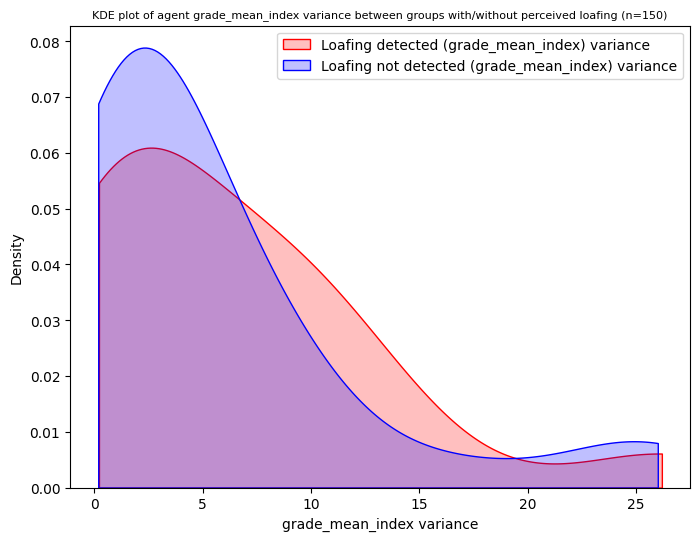

grade_tolerance


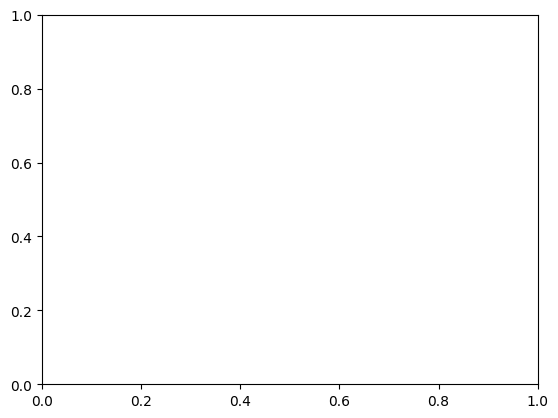

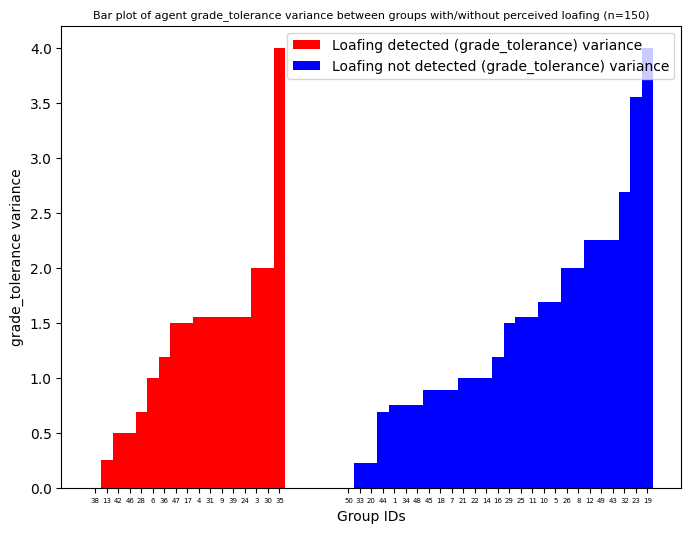

[np.float64(0.75), np.float64(2.25), np.float64(1.0), np.float64(4.0), np.float64(3.555555555555556), np.float64(0.75), np.float64(1.1875), np.float64(0.8888888888888888), np.float64(1.0), np.float64(2.0), np.float64(0.888888888888889), np.float64(0.75), np.float64(0.0), np.float64(1.0), np.float64(2.25), np.float64(0.8888888888888888), np.float64(1.6875), np.float64(1.5), np.float64(2.0), np.float64(1.5555555555555554), np.float64(1.6875), np.float64(0.2222222222222222), np.float64(1.5555555555555554), np.float64(2.25), np.float64(0.6875), np.float64(0.22222222222222224), np.float64(2.6875)]


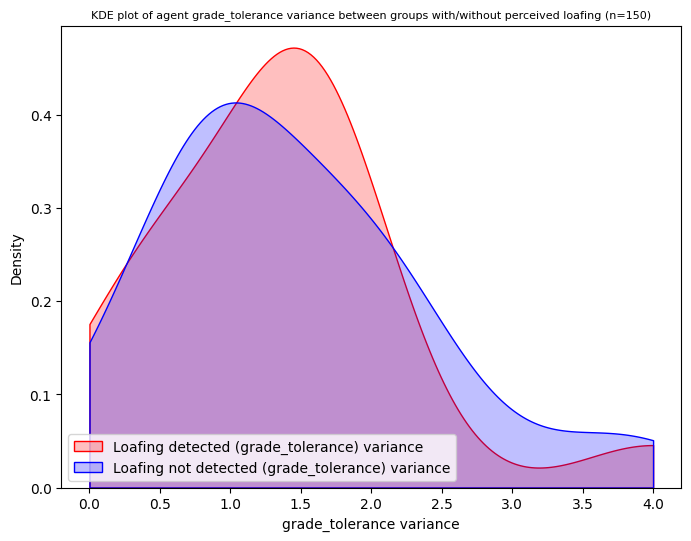

In [33]:
loaf_variances, no_loaf_variances = plot_group_stats(comp_at_step_most, a_150, 150, most_header_150_specific, most_run_id_150_specific, high_point_most, g_150, save=True)

In [ ]:
print(np.mean(loaf_variances['mean_value']))
print(np.mean(no_loaf_variances['mean_value']))

In [ ]:
print(np.mean(loaf_variances['tolerance']))
print(np.mean(no_loaf_variances['tolerance']))

In [ ]:
print(np.mean(loaf_variances['grade_mean_index']))
print(np.mean(no_loaf_variances['grade_mean_index']))

# Comprative plot for (probably) just std mean value agent analysis

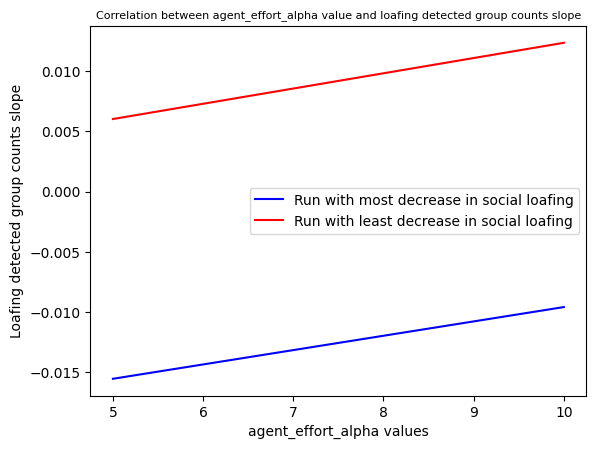

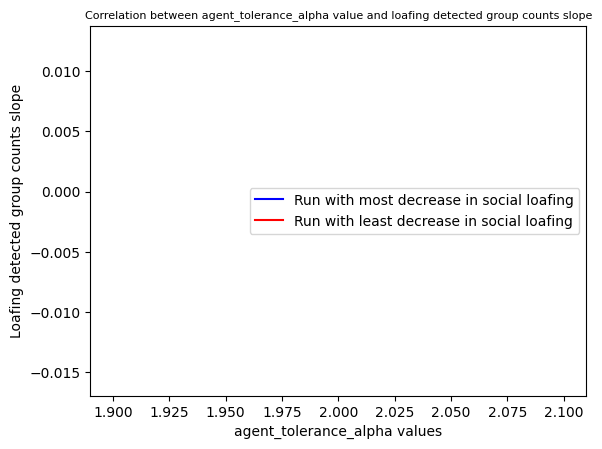

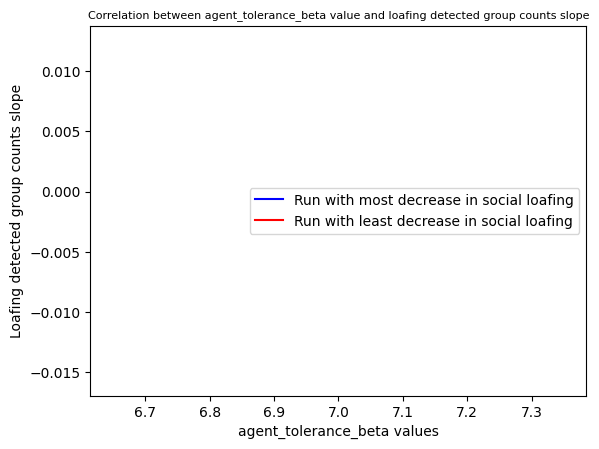

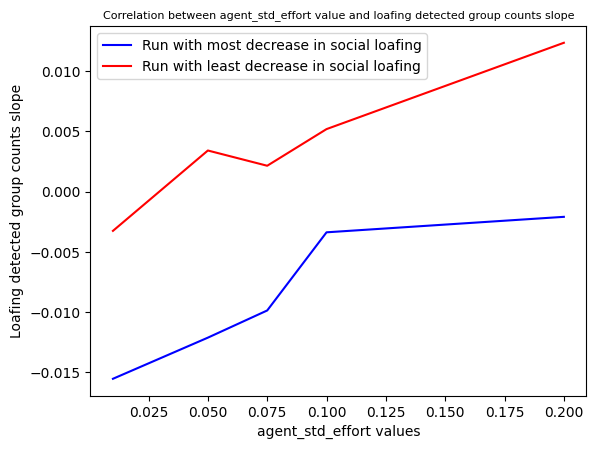

In [50]:
plot_both_correlations(correlates, reversed_correlates, 13, 11, save=True)